# P4: Advanced Lane Finding

In [2]:
# Importing dependencies
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip, clips_array, concatenate_videoclips, CompositeVideoClip
from IPython.display import HTML
%matplotlib inline

# 1. Pipeline (single images)

## 1.1. Camera Calibration

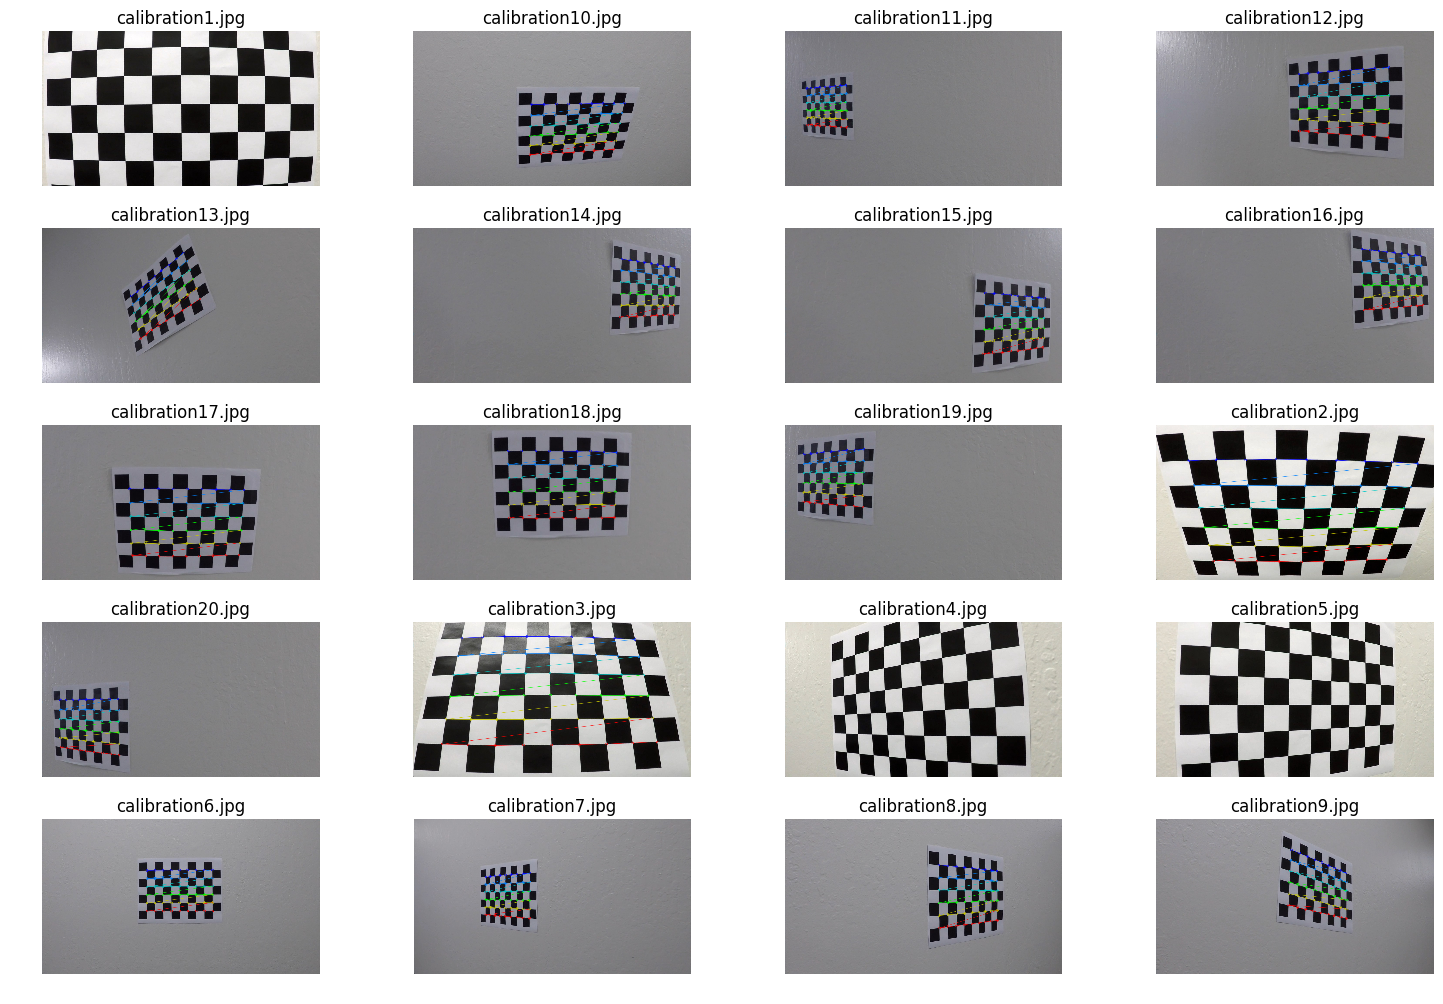

In [19]:
# Preparing object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Making a list of calibration images
images = glob.glob('./camera_calibration/calibration*.jpg')

# Preparing plots for drawing calibration images 
f, ax = plt.subplots(nrows=5, ncols=4, figsize=(15,10))
k, j = 0, 0
f.tight_layout()

# Searching the chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Finding the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Drawing the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    # Displaying calibration images
    ax[k,j].imshow(img)
    ax[k,j].axis('off')
    ax[k,j].set_title(fname[fname.find('\\')+1:])
    j += 1
    if j%4 == 0:
        j = 0
        k +=1

# Calculating distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Saving distortion coefficients into pickle file
f = open('dist_coeff.p', 'wb')
pickle.dump({'mtx': mtx, 'dist':dist}, f, pickle.HIGHEST_PROTOCOL)
f.close()

For some calibration images in above, the function 'cv2.findChessboardCorners' didn't find corners, because part of chessboard displayed on these images doesn't include all 9x6 corners which we are looking for.

## 1.2. Distortion Correction

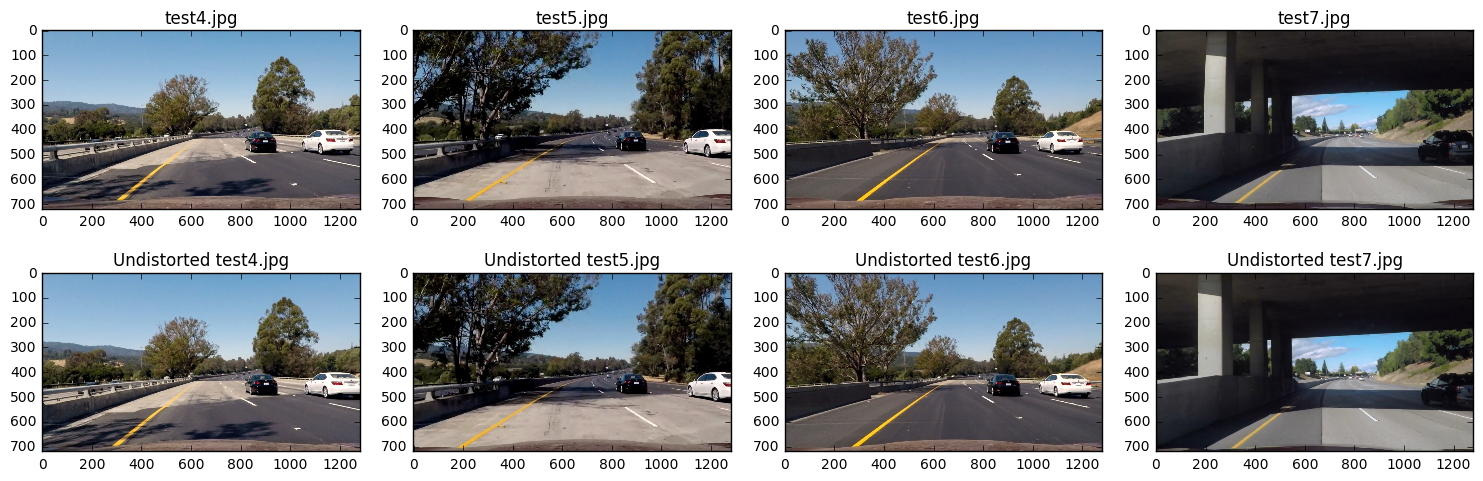

In [23]:
# Loading distortion coefficients from pickle file
f = open('dist_coeff.p', 'rb')
dist_coeff = pickle.load(f)
f.close()

# Undistorting test images
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
f.tight_layout()
i = 0
files = [x for x in os.listdir('test_images/') if ('.db' not in x)]
for file in files:
    # Reading image
    img = mpimg.imread('test_images/' + file)
    # Applying undistortion
    undist = cv2.undistort(img, dist_coeff['mtx'], dist_coeff['dist'], None, dist_coeff['mtx'])
    # Saving image
    plt.imsave('output_images/'+'undist_'+file, undist)
    # Displaying examples
    if ('4' in file) or ('5' in file) or ('6' in file) or ('7' in file):
        ax[0,i].imshow(img)
        ax[0,i].set_title(file)
        ax[1,i].imshow(undist)
        ax[1,i].set_title('Undistorted '+file)
        i += 1

If take a look at a car (the closest to the right border of images), we can see the different distances between the car and right border.

## 1.3. Binary Image

In [3]:
# Function for building a binary image
def binary_image(img, yuv_thresh=(0,110), hsv_thresh=(240,255), sobel_thresh=(40,100), sobel_kernel=3):   
    # Converting an image to YUV color space
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)    
    # Applying a threshold to the V channel
    yuv_channel = yuv[:,:,2]
    yuv_binary = np.zeros_like(yuv_channel)
    yuv_binary[(yuv_channel >= yuv_thresh[0]) & (yuv_channel <= yuv_thresh[1])] = 1
    
    # Converting an image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Applying a threshold to the V channel
    hsv_channel = hsv[:,:,2]
    hsv_binary = np.zeros_like(hsv_channel)
    hsv_binary[(hsv_channel >= hsv_thresh[0]) & (hsv_channel <= hsv_thresh[1])] = 1
    
    # Converting an image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculating Sobel operator
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculating the gradient magnitude
    magnitude = np.sqrt(sobelx**2+0.01*sobely**2)
    # Rescaling to 8 bit
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    # Applying a threshold
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Combining thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(yuv_binary == 1) | (hsv_binary == 1) | (sobel_binary == 1)] = 1
    
    return combined_binary

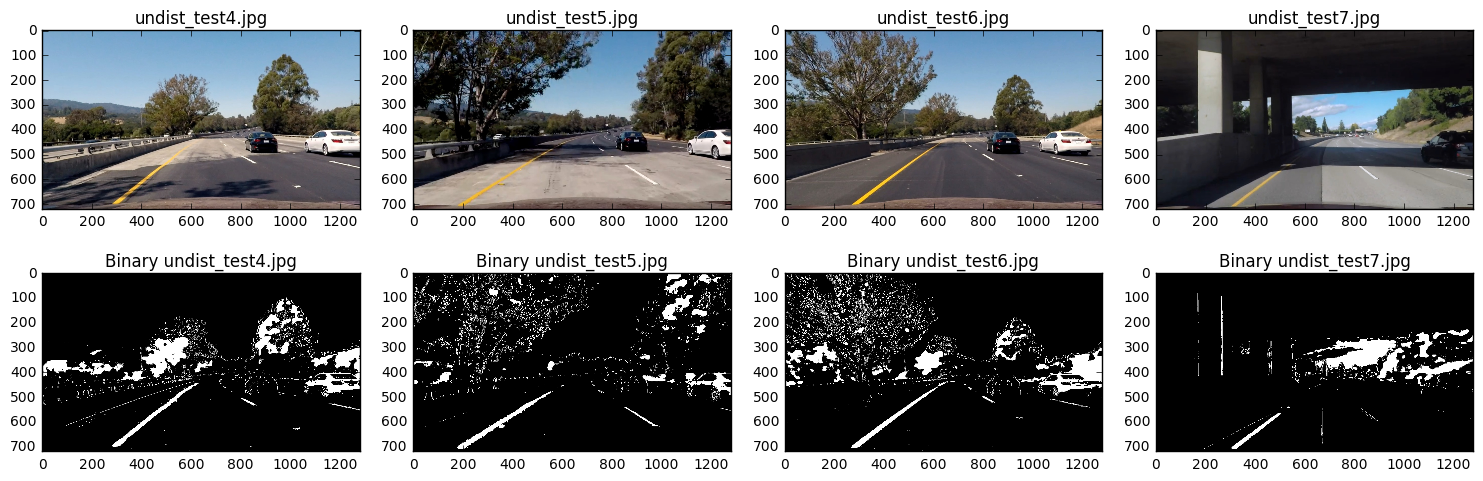

In [32]:
# Transforming undistorted images into binary
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
f.tight_layout()
i = 0
files = [x for x in os.listdir('output_images/') if ('.db' not in x) and ('undist' in x)]
for file in files:
    # Reading image
    img = mpimg.imread('output_images/' + file)
    # Applying binary transform
    binary = binary_image(img)
    # Saving image
    plt.imsave('output_images/'+'binary_'+file, binary, cmap='gray')
    # Displaying images
    if ('4' in file) or ('5' in file) or ('6' in file) or ('7' in file):
        ax[0,i].imshow(img)
        ax[0,i].set_title(file)
        ax[1,i].imshow(binary, cmap='gray')
        ax[1,i].set_title('Binary '+file)
        i += 1

In all pictures in above we can clearly see yellow and white lane lines with minimal details of other objects around.

## 1.4. Perspective transform

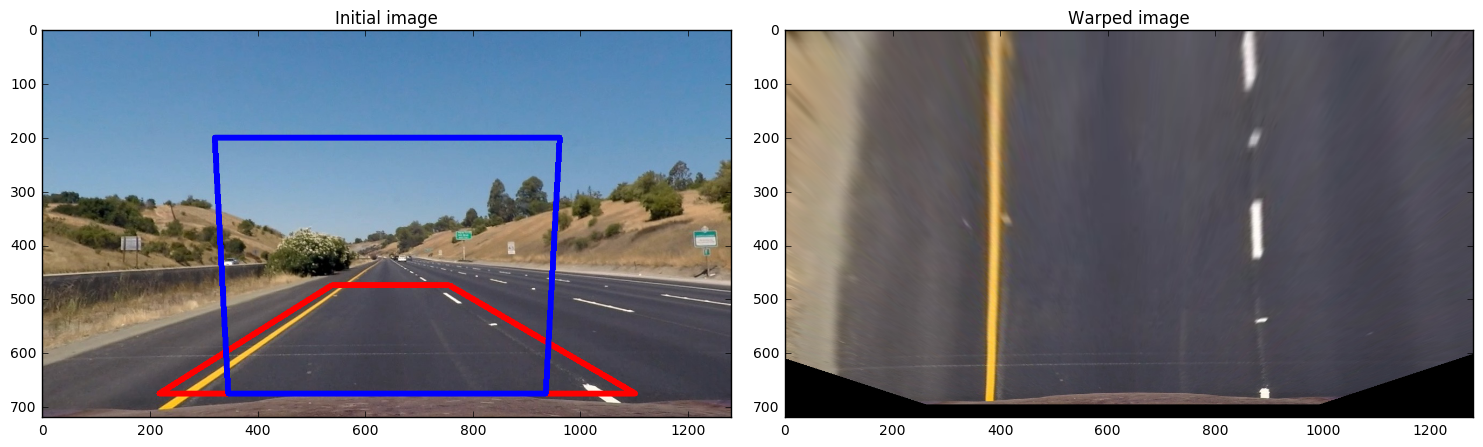

In [43]:
# Taking example of an undistorted image
ini_img = mpimg.imread('.\\output_images\\undist_straight_lines1.jpg')
img = np.copy(ini_img)

# Defining source and destination points for perspective transform
src_top_l = (int(img.shape[1]*0.42), int(img.shape[0]*0.66))
src_top_r = (int(img.shape[1]*0.59), int(img.shape[0]*0.66))
src_bottom_l = (int(img.shape[1]*0.17), int(img.shape[0]*0.94))
src_bottom_r = (int(img.shape[1]*0.86), int(img.shape[0]*0.94))

dst_top_l = (int(img.shape[1]*0.25), int(img.shape[0]*0.28))
dst_top_r = (int(img.shape[1]*0.75), int(img.shape[0]*0.28))
dst_bottom_l = (int(img.shape[1]*0.27), int(img.shape[0]*0.94))
dst_bottom_r = (int(img.shape[1]*0.73), int(img.shape[0]*0.94))

src = np.float32([src_top_r, src_bottom_r, src_bottom_l, src_top_l])
dst = np.float32([dst_top_r, dst_bottom_r, dst_bottom_l, dst_top_l])

# Displaying an initial image with source and destination points perspective transform
cv2.line(img, src_bottom_l, src_top_l, (255,0,0), 10)
cv2.line(img, src_bottom_r, src_top_r, (255,0,0), 10)
cv2.line(img, src_bottom_l, src_bottom_r, (255,0,0), 10)
cv2.line(img, src_top_l, src_top_r, (255,0,0), 10)
cv2.line(img, dst_bottom_l, dst_top_l, (0,0,255), 10)
cv2.line(img, dst_bottom_r, dst_top_r, (0,0,255), 10)
cv2.line(img, dst_bottom_l, dst_bottom_r, (0,0,255), 10)
cv2.line(img, dst_top_l, dst_top_r, (0,0,255), 10)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
f.tight_layout()
ax[0].imshow(img)
ax[0].set_title('Initial image')

# Calculating transform and inverse transform matrix
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

# Displaying resulting image after applying perspective transform
ax[1].imshow(cv2.warpPerspective(ini_img, M, (ini_img.shape[1], ini_img.shape[0]), flags=cv2.INTER_LINEAR))
ax[1].set_title('Warped image')

# Saving perspective coefficients into pickle file
f = open('persp_coeff.p', 'wb')
pickle.dump({'M': M, 'M_inv':M_inv}, f, pickle.HIGHEST_PROTOCOL)
f.close()

In the picture on the right lane lines look parallel. It's the objective of perspective transform.

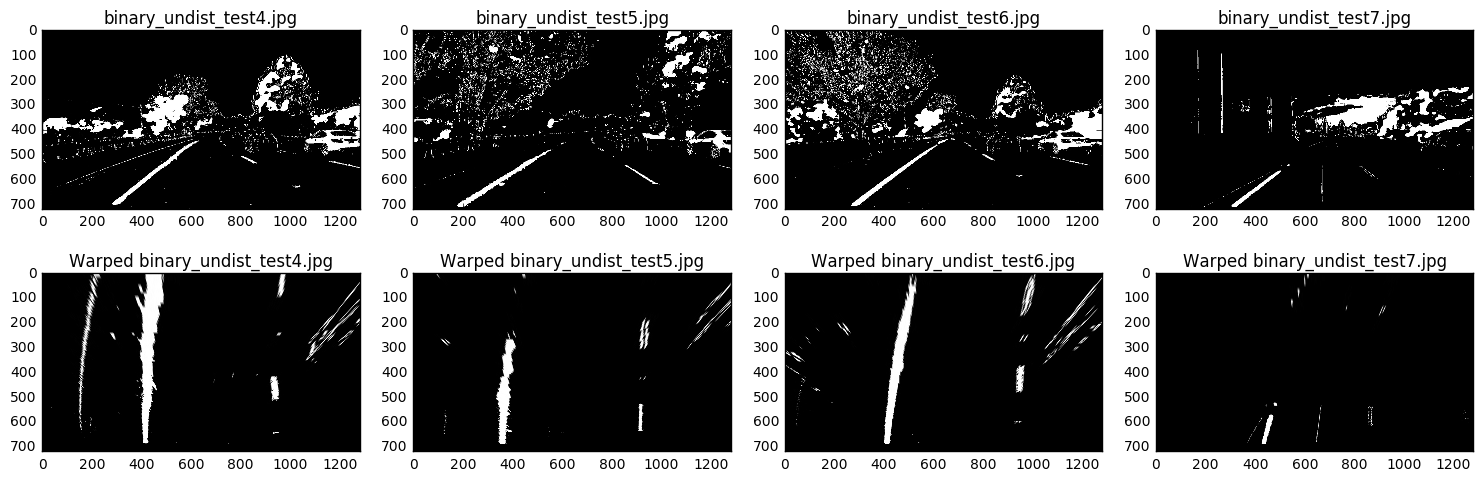

In [45]:
# Applying perspective transform to binary images 
f = open('persp_coeff.p', 'rb')
persp_coeff = pickle.load(f)
f.close()

# Transforming undistorted images into binary
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
f.tight_layout()
i = 0
files = [x for x in os.listdir('output_images/') if ('.db' not in x) and ('binary' in x)]
for file in files:
    # Reading image
    img = mpimg.imread('output_images/' + file)
    # Applying perspective transform
    warped = cv2.warpPerspective(img, persp_coeff['M'], (img.shape[1], img.shape[0]))
    # saving image
    plt.imsave('output_images/'+'warped_'+file, warped)
    # Displaying images
    if ('4' in file) or ('5' in file) or ('6' in file) or ('7' in file):
        ax[0,i].imshow(img)
        ax[0,i].set_title(file)
        ax[1,i].imshow(warped, cmap='gray')
        ax[1,i].set_title('Warped '+file)
        i += 1

## 1.5. Lane Lines Detection

In [4]:
# Function for Lane Lines detection on warped binary images
# based on 'Peaks in a Histogram' method
def process_image(img):
    # Undistorting image
    undist_img = cv2.undistort(img, dist_coeff['mtx'], dist_coeff['dist'], None, dist_coeff['mtx'])    
    # Getting binary image
    binary = binary_image(undist_img)
    binary_3ch = np.dstack((binary, binary, binary))*255    
    # Applying perspective transform
    binary_warped = cv2.warpPerspective(binary, persp_coeff['M'], (img.shape[1], img.shape[0]))    
    # Identifying the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    # Setting the width of the windows
    margin = 90    
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Taking a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
    # Finding the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choosing the number of sliding windows
    nwindows = 9    
    # Setting height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Creating empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identifying window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identifying the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Appending these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenating the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extracting left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fitting a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Creating an image to draw on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Coloring left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generating a polygon to illustrate the search window area
    # And recasting the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Drawing the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    prelim_result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Recasting the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    road = np.zeros_like(img)
    cv2.fillPoly(road, np.int_([pts]), color=[0,255,0])
  
    # Warping the blank back to original image space using inverse perspective matrix (Minv)
    road_warped = cv2.warpPerspective(road, persp_coeff['M_inv'], (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, road_warped, 0.7, 0)
    
    # Defining conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fitting new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    cv2.putText(result, 'Radius of Curvature = ' +str(round((left_curverad+right_curverad)/2,3))+'m', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-binary_warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'

    cv2.putText(result, 'Vehicle is ' +str(abs(round(center_diff,3)))+'m '+side_pos+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return prelim_result, result

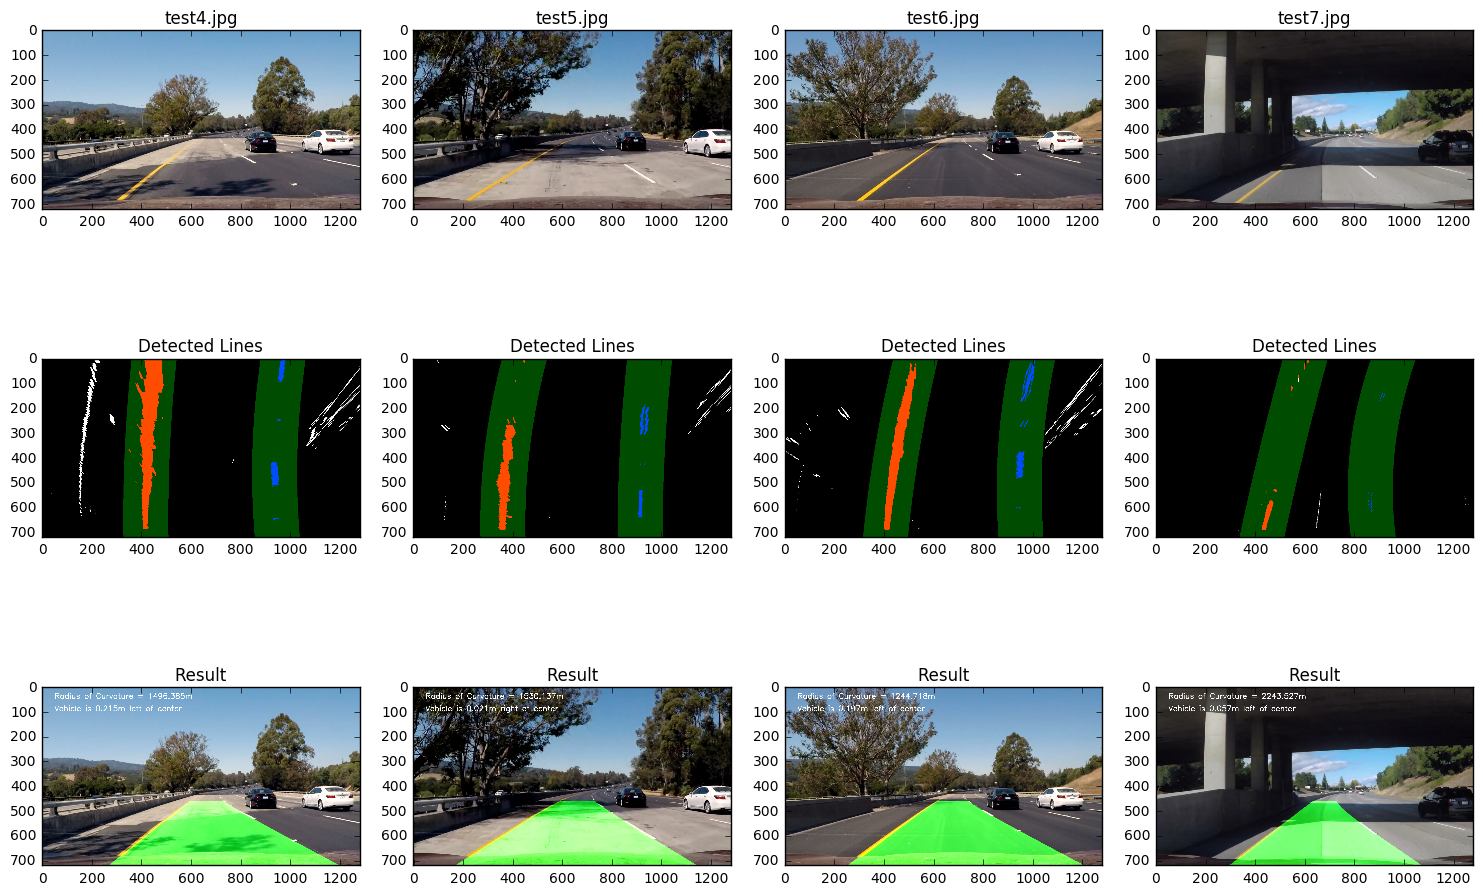

In [5]:
# Loading distortion coefficients from pickle file
f = open('dist_coeff.p', 'rb')
dist_coeff = pickle.load(f)
f.close()

# Loading perspective coefficients from pickle file
f = open('persp_coeff.p', 'rb')
persp_coeff = pickle.load(f)
f.close()

# Transforming undistorted images into binary
f, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,10))
f.tight_layout()
i = 0
files = [x for x in os.listdir('test_images/') if ('.db' not in x)]
for file in files:
    # Reading image
    img = mpimg.imread('test_images/' + file)
    # Applying process_image function
    prelim_result, result = process_image(img)
    # Saving images
    plt.imsave('output_images/'+'prelim_result_'+file, prelim_result)
    plt.imsave('output_images/'+'result_'+file, result)

    # Displaying images
    if ('4' in file) or ('5' in file) or ('6' in file) or ('7' in file):
        ax[0,i].imshow(img)
        ax[0,i].set_title(file)
        ax[1,i].imshow(prelim_result)
        ax[1,i].set_title('Detected Lines')
        ax[2,i].imshow(result,)
        ax[2,i].set_title('Result')
        i += 1

# 2. Pipeline (video)

## 2.1. Modifying Lane Lines Detection fucntion
Pipeline for video include all steps of processing single image, but there is no need to do blind search lane lines in the next frame of video since we know positions from previous frame. Let's modify Lane Lines Detection fucntion.

In [6]:
# Modifying Lane Lines Detection function for video
def process_image1(img):
    global first_image, left_fit, right_fit
    # Undistorting image
    undist_img = cv2.undistort(img, dist_coeff['mtx'], dist_coeff['dist'], None, dist_coeff['mtx'])
    # Getting binary image
    binary = binary_image(undist_img)
    binary_3ch = np.dstack((binary, binary, binary))*255
    # Applying perspective transform
    binary_warped = cv2.warpPerspective(binary, persp_coeff['M'], (img.shape[1], img.shape[0]))
    # Identifying the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Setting the width of the windows
    margin = 90    
    # Set minimum number of pixels found to recenter window
    minpix = 30

    if first_image:
        # Taking a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Finding the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choosing the number of sliding windows
        nwindows = 9    
        # Setting height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Creating empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identifying the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Appending these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenating the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fitting a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extracting left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fitting a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generating x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recasting the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    road = np.zeros_like(img)
    cv2.fillPoly(road, np.int_([pts]), color=[0,255,0])
  
    persp_img = cv2.warpPerspective(undist_img, persp_coeff['M'], (img.shape[1], img.shape[0]))
    bird_eye_view = cv2.addWeighted(persp_img, 1, road, 0.7, 0)

    # Warping the blank back to original image space using inverse perspective matrix (Minv)
    road_warped = cv2.warpPerspective(road, persp_coeff['M_inv'], (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(img, 1, road_warped, 0.7, 0)
    
    # Defining conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fitting new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculating the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature = ' +str(round((left_curverad+right_curverad)/2,3))+'m', (50,50), font, 1, (255, 255, 255), 2)
    
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-binary_warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <=0:
        side_pos = 'right'

    cv2.putText(result, 'Vehicle is ' +str(abs(round(center_diff,3)))+'m '+side_pos+' of center', (50,100), font, 1, (255, 255, 255), 2)
    first_image = False
    
    title1 = np.zeros((40, 300, 3), dtype=np.uint8)
    cv2.putText(title1, 'Binary image', (30, 30), font, 0.75, (255,255,255), 2)

    title2 = np.zeros((40, 300, 3), dtype=np.uint8)
    cv2.putText(title2, 'Bird eye view', (30, 30), font, 0.75, (255,255,255), 2)
    
    # Combining output image with additional information
    CombinedScreen = np.zeros((720, 1920, 3), dtype=np.uint8)
    CombinedScreen[0:720, 0:1320] = cv2.resize(result, (1320,720), interpolation=cv2.INTER_AREA)
    CombinedScreen[10:50, 1550:1850] = title1
    CombinedScreen[55:355, 1370:1920] = cv2.resize(binary_3ch, (550,300), interpolation=cv2.INTER_AREA)
    CombinedScreen[365:405, 1550:1850] = title2
    CombinedScreen[415:715, 1370:1920] = cv2.resize(bird_eye_view, (550,300), interpolation=cv2.INTER_AREA)
    
    return CombinedScreen

## 2.2. Processing 'project_video.mp4'

In [7]:
# Loading distortion coefficients from pickle file
f = open('dist_coeff.p', 'rb')
dist_coeff = pickle.load(f)
f.close()

# Loading perspective coefficients from pickle file
f = open('persp_coeff.p', 'rb')
persp_coeff = pickle.load(f)
f.close()

first_image = True

input_clip = VideoFileClip('project_video.mp4')
output_clip = input_clip.fl_image(process_image1)
%time output_clip.write_videofile('output_project_video_1.mp4', audio=False)

[MoviePy] >>>> Building video output_project_video_1.mp4
[MoviePy] Writing video output_project_video_1.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:36<00:00,  2.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_1.mp4 

Wall time: 7min 40s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_project_video_1.mp4'))

## 2.3. Processing 'challenge_video.mp4'

In [71]:
# Loading distortion coefficients from pickle file
f = open('dist_coeff.p', 'rb')
dist_coeff = pickle.load(f)
f.close()

# Loading perspective coefficients from pickle file
f = open('persp_coeff.p', 'rb')
persp_coeff = pickle.load(f)
f.close()

first_image = True

input_clip = VideoFileClip('challenge_video.mp4')
output_clip = input_clip.fl_image(process_image1)
%time output_clip.write_videofile('output_challenge_video_1.mp4', audio=False)

[MoviePy] >>>> Building video output_challenge_video_1.mp4
[MoviePy] Writing video output_challenge_video_1.mp4


100%|████████████████████████████████████████| 485/485 [02:58<00:00,  2.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video_1.mp4 

Wall time: 3min 1s


In [75]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_challenge_video_1.mp4'))